# Instalações

In [1]:
# Install accelerate, which allows to perform the fine tunning
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


# Imports

In [89]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from datasets import Dataset
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Constants

In [67]:
SEED = 42
BATCH_SIZE = 64
MODEL = 'distilbert-base-uncased'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Functions

In [49]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

# Processing

## Reading the Dataset

In [21]:
textual_data = pd.read_csv('/content/drive/MyDrive/Datasets/Texts/Dmoz-Science.csv')\
                    .drop(columns=['file_name'])\

textual_data

,text,class
0,Texas A&amp;M Horticultural Extension - Vegeta...,Agriculture
1,Algaculture Information from Wikipedia on this...,Agriculture
2,Annual Canarygrass Factsheet on this grain cro...,Agriculture
3,Black Sigatoka Photographs and information on ...,Agriculture
4,Irrigation Training and Research Center Univer...,Agriculture
...,...,...
5995,Canmet Energy Technology Center Information ab...,Technology
5996,Utah Space Association Provides information ab...,Technology
5997,Mission 51-L Provides a critical view of the r...,Technology
5998,"New York (SEAoNY) News announcements, committe...",Technology


In [30]:
label_encoder = LabelEncoder()
label_encoder.fit(textual_data['class'])

textual_data['label'] = label_encoder.transform(textual_data['class'])
textual_data

,text,class,label
0,Texas A&amp;M Horticultural Extension - Vegeta...,Agriculture,0
1,Algaculture Information from Wikipedia on this...,Agriculture,0
2,Annual Canarygrass Factsheet on this grain cro...,Agriculture,0
3,Black Sigatoka Photographs and information on ...,Agriculture,0
4,Irrigation Training and Research Center Univer...,Agriculture,0
...,...,...,...
5995,Canmet Energy Technology Center Information ab...,Technology,11
5996,Utah Space Association Provides information ab...,Technology,11
5997,Mission 51-L Provides a critical view of the r...,Technology,11
5998,"New York (SEAoNY) News announcements, committe...",Technology,11


<Axes: ylabel='Frequency'>

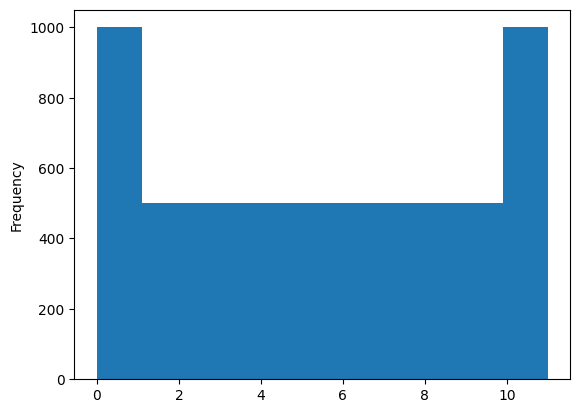

In [64]:
textual_data['label'].plot.hist()

In [32]:
dataset = Dataset.from_pandas(textual_data.drop(columns='class'))
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 6000
})

In [33]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4800
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
})

In [51]:
train_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42) # The test in train dataset will the the validadation for training
test_dataset = dataset['test']

In [52]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3840
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 960
    })
})

In [53]:
test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1200
})

## Creating the classes for fine-tuning

### Tokenizer

In [39]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [43]:
# Just testing the tokenizer

text_test = train_dataset['train'][0]['text']
text_test

'Process in Our Participatory Action The article proposes some ways of distinguishing action research and learning processes in research practices, particularly with regard to experiences of reconciliation at an inter-racial level. '

In [46]:
encoded_text = tokenizer(text_test)
encoded_text

{'input_ids': [101, 2832, 1999, 2256, 2112, 28775, 4502, 7062, 2895, 1996, 3720, 17146, 2070, 3971, 1997, 20852, 2895, 2470, 1998, 4083, 6194, 1999, 2470, 6078, 1010, 3391, 2007, 7634, 2000, 6322, 1997, 16088, 2012, 2019, 6970, 1011, 5762, 2504, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [47]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'process',
 'in',
 'our',
 'part',
 '##ici',
 '##pa',
 '##tory',
 'action',
 'the',
 'article',
 'proposes',
 'some',
 'ways',
 'of',
 'distinguishing',
 'action',
 'research',
 'and',
 'learning',
 'processes',
 'in',
 'research',
 'practices',
 ',',
 'particularly',
 'with',
 'regard',
 'to',
 'experiences',
 'of',
 'reconciliation',
 'at',
 'an',
 'inter',
 '-',
 'racial',
 'level',
 '.',
 '[SEP]']

In [54]:
train_dataset_encoded = train_dataset.map(tokenize, batched=True, batch_size=None)
test_dataset_encoded = test_dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/3840 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [55]:
train_dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3840
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 960
    })
})

### Deep Learning Model

In [60]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=len(label_encoder.classes_)).to(DEVICE)
model

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [69]:
training_args = TrainingArguments(
    output_dir=f'{MODEL}',
    num_train_epochs = 10,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    disable_tqdm=False,
    warmup_steps=500,
    save_total_limit=3,
    load_best_model_at_end = True,
    logging_steps=len(train_dataset['train']) // BATCH_SIZE,
    push_to_hub = False,
    log_level='error'
)

In [73]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_encoded['train'],
    eval_dataset=train_dataset_encoded['test']
)

In [74]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.481200,2.472882
2,2.428800,2.324169
3,2.137600,1.873802
4,1.648500,1.358080
5,1.186800,0.994441
6,0.844900,0.789613
7,0.596300,0.685478
8,0.426700,0.661632
9,0.295800,0.615999
10,0.199800,0.626667


TrainOutput(global_step=600, training_loss=1.224652280807495, metrics={'train_runtime': 352.7352, 'train_samples_per_second': 108.864, 'train_steps_per_second': 1.701, 'total_flos': 914188054118400.0, 'train_loss': 1.224652280807495, 'epoch': 10.0})

### Computing Evaluation Metrics

In [77]:
predictions = trainer.predict(test_dataset_encoded)
predictions

PredictionOutput(predictions=array([[-0.84929746, -0.18753934, -0.37629548, ...,  4.7687516 ,
         0.03696921, -0.6033369 ],
       [-0.51336056, -1.5876267 , -0.5945928 , ..., -0.8190196 ,
        -1.6020355 ,  0.00668102],
       [-0.9515291 , -0.72087073,  0.41927645, ..., -0.3379381 ,
        -1.1088806 , -0.49308997],
       ...,
       [-1.2405851 , -0.01958925, -0.92054516, ..., -0.7277059 ,
        -1.1083695 ,  0.87932414],
       [-1.0901408 , -0.71148485, -0.476592  , ..., -0.39241236,
        -0.99882394, -0.4309544 ],
       [-1.470721  , -1.5675358 , -1.1121904 , ..., -0.62906945,
        -1.5255367 ,  1.5354158 ]], dtype=float32), label_ids=array([9, 6, 3, ..., 8, 3, 3]), metrics={'test_loss': 0.7386705279350281, 'test_runtime': 2.8598, 'test_samples_per_second': 419.612, 'test_steps_per_second': 6.644})

In [79]:
predictions.metrics

{'test_loss': 0.7386705279350281,
 'test_runtime': 2.8598,
 'test_samples_per_second': 419.612,
 'test_steps_per_second': 6.644}

In [82]:
y_preds = np.argmax(predictions.predictions, axis=1)
y_preds

array([9, 6, 3, ..., 8, 3, 3])

In [87]:
accuracy_score(test_dataset_encoded['label'],y_preds)

0.7925

In [88]:
f1_score(test_dataset_encoded['label'],y_preds, average='macro')

0.7917324942773664

In [91]:
confusion_matrix(test_dataset_encoded['label'], y_preds)

array([[91,  0,  2,  0,  0,  4,  0,  0,  0,  0,  0,  1],
       [ 0, 93,  1,  0,  3,  0,  0,  0,  4,  1,  2,  2],
       [ 5,  1, 90,  4,  1,  8,  0,  1,  0,  0,  3,  0],
       [ 0,  0,  2, 76,  0,  3,  6,  0,  3,  2,  3,  3],
       [ 0,  3,  4,  0, 82,  7,  2,  2,  2,  0,  2,  1],
       [ 7,  1,  2,  1,  6, 61,  3,  0,  2,  2,  2,  4],
       [ 0,  0,  0,  8,  2,  4, 90,  1,  2,  0,  0,  4],
       [ 0,  0,  2,  1,  0,  0,  0, 88,  4,  0,  0,  4],
       [ 0,  4,  0,  4,  0,  0,  7,  7, 64,  3,  3,  9],
       [ 1,  1,  1,  1,  0,  0,  0,  1,  3, 66,  2,  0],
       [ 3,  0,  0,  0,  3,  3,  0,  7,  0,  2, 78,  4],
       [ 3,  1,  2,  3,  5,  5,  4,  2,  5,  0,  0, 72]])